# Install detectron2

In [1]:
#dependencies
!pip install --upgrade pip
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
#import torch, torchvision
#torch.__version__
#torchvision.__version__
#!gcc --version

# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Requirement already up-to-date: pip in /opt/conda/lib/python3.7/site-packages (20.0.2)
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9 MB 41 kB/s  eta 0:00:011
     |████████████████████████████████| 4.0 MB 592 kB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
     |████████████████████████████████| 274 kB 2.5 MB/s eta 0:00:01
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44075 sha256=d8e11abac091c9c35f42913d7b628415a813af0ba53fe541cab30bd4ee0df264
  Stored in directory: /home/Deep_Learner/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting

  Created wheel for fvcore: filename=fvcore-0.1.dev200325-py3-none-any.whl size=38930 sha256=53746d0194e782dbeaf83e58e41c02b0902344d4077404ce4226ad08244f3b16
  Stored in directory: /home/Deep_Learner/.cache/pip/wheels/d6/25/b1/a3d3dfde6eef5ef23ed5a3fbc908fe134bae8f07b44741140f
Successfully built fvcore


# Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

import sys
sys.path.append('../preprocessing_pipeline/python-wsi-preprocessing/')
import wsi
#from wsi import tiles, util

from bokeh.io import output_notebook
from typing import Dict, List, Callable
import os
import pandas
import pandas as pd
import numpy
import numpy as np
import torch, torchvision
import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

import PIL
from PIL import Image

import fastai
from fastai import vision
import matplotlib.pyplot as plt
import matplotlib.patches
import pycocotools
from pycocotools import mask
from itertools import groupby
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

 
PATH = Path('/home/Deep_Learner/shared/Datasets/2018_Data_Science_Bowl/')
STAGE1_TRAIN = PATH/'stage1_train'
STAGE1_TEST = PATH/'stage1_test'
EXTRA_DATA = PATH/'extra_data'

STAGE1_TRAIN_LABELS = PATH/'stage1_train_labels.csv'
STAGE1_TEST_LABELS = PATH/'stage1_solution.csv'

STAGE2_TEST = PATH/'stage2_test_final'
STAGE2_TEST_SAMPLE_SUBMISSION = PATH/'stage2_sample_submission_final.csv'


seed = 19
np.random.seed(seed)

# util functions

In [2]:
def show_np(arr:numpy.ndarray):
    plt.imshow(arr)
    plt.show()
    
from matplotlib.pyplot import imshow
def show_pil(path:pathlib.Path):    
    imshow(np.asarray(Image.open(path)))
    plt.show()

def get_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    """
    Arguments:
        base_path: here ~/2018_Data_Science_Bowl/stage1_train/   or   ~/2018_Data_Science_Bowl/stage1_test/
    """
    for p in base_path.ls():
        if img_id in p.stem:
            return p

def get_masks_path_from_id(img_id:str, base_path:pathlib.Path)->pathlib.Path:
    """
    Arguments:
        base_path: here ~/2018_Data_Science_Bowl/stage1_train/   or   ~/2018_Data_Science_Bowl/stage1_test/
    """
    return get_path_from_id(img_id, base_path)/'masks'
        
def open_mask_as_np(path:pathlib.Path)->numpy.ndarray:
    return np.asarray(PIL.Image.open(path), dtype=np.bool)

def show_np_with_bboxes(img:numpy.ndarray, bboxes:List[numpy.ndarray]):
    """
    Arguments:
        img: img as numpy array
        bboxes: List of bounding boxes where each bbox is a numpy array: 
                array([ x-upper-left, y-upper-left,  width,  height]) 
                e.g. array([ 50., 211.,  17.,  19.])
    """    
    # Create figure and axes
    fig,ax = plt.subplots(1)    
    # Display the image
    ax.imshow(img)    
    # Create a Rectangle patch for each bbox
    for b in bboxes:
        rect = matplotlib.patches.Rectangle((b[0],b[1]),b[2],b[3],linewidth=1,edgecolor='r',facecolor='none')    
        # Add the patch to the Axes
        ax.add_patch(rect)    
    plt.show()    

def merge_masks(masks:List[numpy.ndarray], shape:tuple=(256,256))->numpy.ndarray:
    merged_mask = np.zeros((shape[0],shape[1]), dtype=np.bool)
    for mask in masks:
        merged_mask = np.maximum(merged_mask, mask)
    return merged_mask

def merge_masks_from_path(path:pathlib.Path, shape:tuple=(256,256))->numpy.ndarray:
    masks = [open_mask_as_np(p) for p in path.ls()]
    return merge_masks(masks, shape)


def rle_encode(mask_np:numpy.ndarray)->List[int]:
    '''
    mask_np: numpy array of shape (height, width), 1 = mask, 0 = background
    Returns run length as list
    '''
    dots = np.where(mask_np.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def rle_from_list_to_string(rle_as_list:List[int])->str:
    return ' '.join([str(e) for e in rle_as_list])

def rle_decode(mask_rle:str, shape:tuple=(256, 256))->numpy.ndarray:
    '''
    Arguments:
        mask_rle: run-length as string formated (start length) e.g. "6908 1 7161 8 7417 8"
        shape: (height,width) of array to return
    Returns: 
        numpy array, True == mask, False == background
    '''
    #print('rle_decode(mask_rle = ', mask_rle)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(shape[0]*shape[1], dtype=np.bool)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = True
    # Needed to align to RLE direction
    return mask.reshape(shape).T

def get_mask_list_from_rle_for_one_id(img_id:str, 
                                      df:pandas.DataFrame, 
                                      coloumn_name_ids:str='ImageId',
                                      coloumn_name_rle:str='EncodedPixels',
                                      shape:tuple=(256,256))->List[numpy.ndarray]:
    """
    Arguments:
        shape: tuple (width, height)
    Returns:
        
    """
    masks_rle_df = df.loc[df[coloumn_name_ids] == img_id]
    masks = []
    for index, row in masks_rle_df.iterrows():
        #print(row[coloumn_name_rle])
        masks.append(rle_decode(row[coloumn_name_rle], shape))
    return masks

def mask_to_bbox(mask_np:numpy.ndarray)->numpy.ndarray:
    """
    Arguments: 
        mask_np: binary mask as numpy array where mask == True or 1 or 1.0 and background == False or 0 or 0.0
    Returns:
        bounding box as numpy array: array([ x-upper-left, y-upper-left,  width,  height]) 
                                        e.g. array([ 50., 211.,  17.,  19.])
    """
    return pycocotools.mask.toBbox(pycocotools.mask.encode(np.asarray(mask_np, order="F")))


def rle_encode_pycoco(mask_np:numpy.ndarray)->dict:
    '''
    Arguments:
        mask_np: numpy array of shape (height, width), 1 = mask, 0 = background
    Returns: 
        dict with size and per-pixel segmentation mask in COCO's RLE format.        
    '''
    #option 1
    return pycocotools.mask.encode(np.asarray(mask, order="F"))
    #option 2
    #rle = {'counts': [], 'size': list(mask_np.shape)}
    #counts = rle.get('counts')
    #for i, (value, elements) in enumerate(groupby(mask_np.ravel(order='F'))):
    #    if i == 0 and value == 1:
    #        counts.append(0)
    #    counts.append(len(list(elements)))
    #return rle

#!pip install imantics
from imantics import Polygons, Mask
def get_polygon_from_binary_mask(mask_np:numpy.ndarray)->List[float]:
    """
    Arguments:
        binary mask as numpy array
    Returns:
        list[int] is one simple polygon in the format of [x1, y1, ..., xn, yn]
    """
    return [float(c) for c in list(Mask(mask_np).polygons()[0])]

# some util examples

## load csv

In [31]:
s1_trn_lbs_df = pd.read_csv(STAGE1_TRAIN_LABELS)

In [ ]:
s1_trn_lbs_df

In [ ]:
img_id = s1_trn_lbs_df.iloc[0][0];img_id

## merge existing single masks of one image - example

In [ ]:
img_id_p = get_path_from_id(img_id, STAGE1_TRAIN)

In [ ]:
masks_path = get_masks_path_from_id(img_id, STAGE1_TRAIN);masks_path

In [ ]:
masks_np = [open_mask_as_np(p) for p in masks_path.ls()]

In [ ]:
merged_mask = merge_masks_from_path(masks_path,(256,256))

In [ ]:
show_np(merged_mask)

## decode run length encoding to mask - example

In [ ]:
masks = get_mask_list_from_rle_for_one_id(img_id, s1_trn_lbs_df)

In [ ]:
merged_mask = merge_masks(masks)

In [ ]:
show_np(merged_mask)

## get bounding box from mask in format x,y (left upper corner); width, heigth - example

In [ ]:
img_id

In [ ]:
img_p = get_path_from_id(img_id, STAGE1_TRAIN);img_p

In [ ]:
masks_p = get_masks_path_from_id(img_id, STAGE1_TRAIN);masks_p

In [ ]:
bboxes = []
for p in masks_p.ls():
    mask_np = open_mask_as_np(p)
    bboxes.append(mask_to_bbox(mask_np))

In [ ]:
merged_mask = merge_masks_from_path(masks_p)

In [ ]:
show_np_with_bboxes(merged_mask,bboxes)

## Custom dataset for nuclei detection

# Data

## imports

In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

## image paths

In [4]:
excluded_ids = ['7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80']

In [5]:
img_paths = [p/'images'/f'{p.name}.png' for p in STAGE1_TRAIN.ls()+STAGE1_TEST.ls()+EXTRA_DATA.ls() if p.name not in excluded_ids]
img_paths_train, img_paths_valid = train_test_split(img_paths, test_size=0.1, random_state=seed)
print(len(img_paths))
print(len(img_paths_train))
print(len(img_paths_valid))

764
687
77


## custom dataset getter

In [6]:
df_rle_labels = pd.concat([pd.read_csv(STAGE1_TRAIN_LABELS), 
                             pd.read_csv(STAGE1_TEST_LABELS)], 
                            ignore_index=True, sort=False)

def get_nuclei_dicts(img_paths:List[pathlib.Path], isTestSet:bool=False):
    """
    Arguments:
        dataset_path: List of pathlib.Path to images
    """

    #img_paths = [Path('/home/Deep_Learner/shared/Datasets/2018_Data_Science_Bowl/stage1_train/420f43d21dbaba42bf8c0995b3a2c85537876d594433770c6c6f3d6b779ec15f/images/420f43d21dbaba42bf8c0995b3a2c85537876d594433770c6c6f3d6b779ec15f.png')]
    
    dataset_dicts = []
    for path in tqdm(img_paths):
        record = {}
        
        img_pil = PIL.Image.open(path)         
        width = img_pil.width
        height = img_pil.height
        
        record["file_name"] = path
        record["image_id"] = path.stem
        record["height"] = height
        record["width"] = width
        
        ###
        #stage1_test set: masks only in run length encoded form in csv file
        #extra_data set: masks only saved as images
        ###
        try:
            masks = [open_mask_as_np(mp) for mp in get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
        except FileNotFoundError:
            masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(width,height))
        
        objs = []
        if not isTestSet:
            for mask in masks:
                obj = {
                    "bbox": list(mask_to_bbox(mask)),
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "segmentation": [get_polygon_from_binary_mask(mask)],
                    #"segmentation": rle_encode_pycoco(mask),
                    "category_id": 0,
                    "iscrowd": 0
                }
                ### detectron throws AssertionError if not (len(polygon) % 2 == 0 and len(polygon) >= 6)
                if len(obj["segmentation"][0]) >= 6:
                    objs.append(obj)
            
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

## register datasets

In [21]:
from detectron2.data import DatasetCatalog, MetadataCatalog

In [22]:
DatasetCatalog.clear()

In [23]:
DatasetCatalog.register("nuclei_train", lambda : get_nuclei_dicts(img_paths_train))
MetadataCatalog.get(f"nuclei_train").set(thing_classes=["nucleus"])

Metadata(name='nuclei_train', thing_classes=['nucleus'])

In [24]:
DatasetCatalog.register("nuclei_valid", lambda : get_nuclei_dicts(img_paths_valid))
MetadataCatalog.get(f"nuclei_valid").set(thing_classes=["nucleus"])

Metadata(name='nuclei_valid', thing_classes=['nucleus'])

## load datasets

In [11]:
nuclei_metadata_train = MetadataCatalog.get(f"nuclei_train")
dataset_dicts_nuclei_train = get_nuclei_dicts(img_paths_train)

In [12]:
nuclei_metadata_valid = MetadataCatalog.get(f"nuclei_valid")
dataset_dicts_nuclei_valid = get_nuclei_dicts(img_paths_valid)

In [13]:
#for d in dataset_dicts_nuclei:
#    for a in d["annotations"]:
#        polygon = a['segmentation']
#        #print(len(polygon[0]))
#        try:
#            assert len(polygon[0]) % 2 == 0 and len(polygon[0]) >= 6
#        except AssertionError:
#            print(len(polygon[0]))

## sort dataset by number of nuclei and inspect it

In [14]:
#key: img_path; value: number of nuclei
path_to_n_objects = {}

for ds in [dataset_dicts_nuclei_train, dataset_dicts_nuclei_valid]:
    for d in ds:
        path_to_n_objects[d['file_name']] = len(d['annotations'])
        
#sort descending by number of nuclei
path_to_n_objects = {k: v for k, v in sorted(path_to_n_objects.items(), key=lambda item: item[1], reverse=True)}

In [15]:
print(f'max number of objects: {list(path_to_n_objects.values())[0]}')
print(f'min number of objects: {list(path_to_n_objects.values())[-1]}')

max number of objects: 1862
min number of objects: 1


In [ ]:
for k, v in list(path_to_n_objects.items())[300:320]:
    print(k)
    print(v)
    show_pil(k)

## some visualization of the data

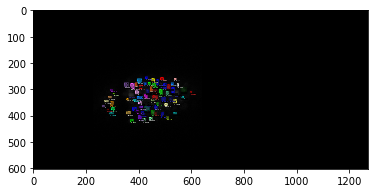

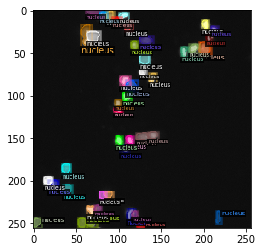

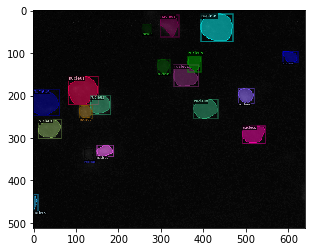

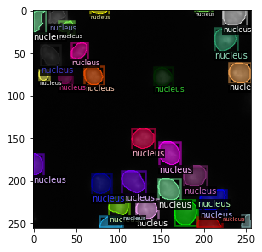

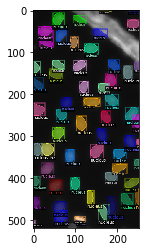

In [17]:
#for d in random.sample(dataset_dicts_nuclei, 3):
for d in dataset_dicts_nuclei_valid[:5]:
    #print(d["file_name"])
    img = cv2.imread(str(d["file_name"]))
    #img = np.asarray(Image.open(p))
    visualizer = Visualizer(img[:, :, ::-1], metadata=nuclei_metadata_valid, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    #cv2.imshow(vis.get_image()[:, :, ::-1])
    show_np(vis.get_image()[:, :, ::-1])

# config 

In [7]:
from detectron2.config import get_cfg

In [8]:
epochs = 40
bs = 1
iterations = int(len(img_paths_train)/bs*epochs);iterations

27480

In [9]:
output_directory = Path('./output/1')

In [10]:
get_cfg().MODEL.RPN

CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['res4'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_WEIGHTS': (1.0, 1.0, 1.0, 1.0), 'SMOOTH_L1_BETA': 0.0, 'LOSS_WEIGHT': 1.0, 'PRE_NMS_TOPK_TRAIN': 12000, 'PRE_NMS_TOPK_TEST': 6000, 'POST_NMS_TOPK_TRAIN': 2000, 'POST_NMS_TOPK_TEST': 1000, 'NMS_THRESH': 0.7})

In [11]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = (f"nuclei_train",)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 20

cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 2.5e-3  
cfg.SOLVER.MAX_ITER = iterations
cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'
cfg.SOLVER.WARMUP_ITERS = 0.3*iterations
#cfg.SOLVER.LR_SCHEDULER_NAME = 'OneCycleLR'

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (nucleus)
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 12000
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 2000

cfg['SEED'] = seed

cfg.OUTPUT_DIR = str(output_directory)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# train

In [57]:
from detectron2.engine import DefaultTrainer

In [66]:
trainer = DefaultTrainer(cfg) 

[04/06 09:51:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

TypeError: 'NoneType' object is not subscriptable

In [25]:
#trainer.resume_or_load(resume=False)
trainer.resume_or_load(resume=True)

In [35]:
trainer.train()

[03/29 18:28:44 d2.engine.train_loop]: Starting training from iteration 0
[03/29 18:28:51 d2.utils.events]:  eta: 1:32:59  iter: 19  total_loss: 3.409  loss_cls: 0.765  loss_box_reg: 0.738  loss_mask: 0.688  loss_rpn_cls: 0.934  loss_rpn_loc: 0.187  time: 0.2047  data_time: 0.1168  lr: 0.000050  max_mem: 5069M
[03/29 18:28:55 d2.utils.events]:  eta: 1:33:35  iter: 39  total_loss: 2.202  loss_cls: 0.515  loss_box_reg: 0.769  loss_mask: 0.619  loss_rpn_cls: 0.167  loss_rpn_loc: 0.158  time: 0.2052  data_time: 0.0002  lr: 0.000100  max_mem: 5069M
[03/29 18:28:59 d2.utils.events]:  eta: 1:32:24  iter: 59  total_loss: 2.014  loss_cls: 0.445  loss_box_reg: 0.758  loss_mask: 0.521  loss_rpn_cls: 0.125  loss_rpn_loc: 0.161  time: 0.2033  data_time: 0.0002  lr: 0.000150  max_mem: 5069M
[03/29 18:29:03 d2.utils.events]:  eta: 1:31:24  iter: 79  total_loss: 1.599  loss_cls: 0.328  loss_box_reg: 0.756  loss_mask: 0.440  loss_rpn_cls: 0.043  loss_rpn_loc: 0.088  time: 0.2014  data_time: 0.0002  lr:

[03/29 18:31:08 d2.utils.events]:  eta: 1:31:18  iter: 679  total_loss: 1.149  loss_cls: 0.249  loss_box_reg: 0.359  loss_mask: 0.300  loss_rpn_cls: 0.039  loss_rpn_loc: 0.141  time: 0.2075  data_time: 0.0003  lr: 0.001696  max_mem: 6480M
[03/29 18:31:12 d2.utils.events]:  eta: 1:31:13  iter: 699  total_loss: 1.225  loss_cls: 0.221  loss_box_reg: 0.379  loss_mask: 0.315  loss_rpn_cls: 0.035  loss_rpn_loc: 0.136  time: 0.2077  data_time: 0.0003  lr: 0.001745  max_mem: 6480M
[03/29 18:31:17 d2.utils.events]:  eta: 1:31:10  iter: 719  total_loss: 0.950  loss_cls: 0.181  loss_box_reg: 0.305  loss_mask: 0.263  loss_rpn_cls: 0.035  loss_rpn_loc: 0.129  time: 0.2077  data_time: 0.0003  lr: 0.001795  max_mem: 6480M
[03/29 18:31:21 d2.utils.events]:  eta: 1:31:11  iter: 739  total_loss: 1.029  loss_cls: 0.198  loss_box_reg: 0.286  loss_mask: 0.270  loss_rpn_cls: 0.044  loss_rpn_loc: 0.123  time: 0.2080  data_time: 0.0003  lr: 0.001845  max_mem: 6480M
[03/29 18:31:25 d2.utils.events]:  eta: 1:31

[03/29 18:33:28 d2.utils.events]:  eta: 1:30:08  iter: 1339  total_loss: 0.985  loss_cls: 0.192  loss_box_reg: 0.282  loss_mask: 0.208  loss_rpn_cls: 0.060  loss_rpn_loc: 0.182  time: 0.2092  data_time: 0.0003  lr: 0.002485  max_mem: 7417M
[03/29 18:33:32 d2.utils.events]:  eta: 1:30:02  iter: 1359  total_loss: 1.113  loss_cls: 0.238  loss_box_reg: 0.345  loss_mask: 0.262  loss_rpn_cls: 0.039  loss_rpn_loc: 0.132  time: 0.2092  data_time: 0.0003  lr: 0.002485  max_mem: 7417M
[03/29 18:33:36 d2.utils.events]:  eta: 1:29:59  iter: 1379  total_loss: 0.961  loss_cls: 0.181  loss_box_reg: 0.277  loss_mask: 0.267  loss_rpn_cls: 0.044  loss_rpn_loc: 0.164  time: 0.2093  data_time: 0.0003  lr: 0.002485  max_mem: 7417M
[03/29 18:33:41 d2.utils.events]:  eta: 1:29:57  iter: 1399  total_loss: 0.923  loss_cls: 0.188  loss_box_reg: 0.288  loss_mask: 0.218  loss_rpn_cls: 0.025  loss_rpn_loc: 0.135  time: 0.2095  data_time: 0.0003  lr: 0.002484  max_mem: 7417M
[03/29 18:33:45 d2.utils.events]:  eta: 

[03/29 18:35:49 d2.utils.events]:  eta: 1:28:51  iter: 1999  total_loss: 1.078  loss_cls: 0.215  loss_box_reg: 0.344  loss_mask: 0.266  loss_rpn_cls: 0.064  loss_rpn_loc: 0.151  time: 0.2107  data_time: 0.0003  lr: 0.002468  max_mem: 7418M
[03/29 18:35:54 d2.utils.events]:  eta: 1:28:50  iter: 2019  total_loss: 0.992  loss_cls: 0.200  loss_box_reg: 0.300  loss_mask: 0.220  loss_rpn_cls: 0.023  loss_rpn_loc: 0.131  time: 0.2107  data_time: 0.0003  lr: 0.002467  max_mem: 7418M
[03/29 18:35:58 d2.utils.events]:  eta: 1:28:46  iter: 2039  total_loss: 0.764  loss_cls: 0.181  loss_box_reg: 0.250  loss_mask: 0.209  loss_rpn_cls: 0.028  loss_rpn_loc: 0.128  time: 0.2107  data_time: 0.0003  lr: 0.002466  max_mem: 7418M
[03/29 18:36:02 d2.utils.events]:  eta: 1:28:42  iter: 2059  total_loss: 1.053  loss_cls: 0.239  loss_box_reg: 0.352  loss_mask: 0.226  loss_rpn_cls: 0.026  loss_rpn_loc: 0.112  time: 0.2107  data_time: 0.0002  lr: 0.002466  max_mem: 7418M
[03/29 18:36:06 d2.utils.events]:  eta: 

[03/29 18:38:11 d2.utils.events]:  eta: 1:26:54  iter: 2659  total_loss: 0.866  loss_cls: 0.197  loss_box_reg: 0.332  loss_mask: 0.249  loss_rpn_cls: 0.013  loss_rpn_loc: 0.088  time: 0.2113  data_time: 0.0002  lr: 0.002443  max_mem: 7418M
[03/29 18:38:15 d2.utils.events]:  eta: 1:27:04  iter: 2679  total_loss: 0.917  loss_cls: 0.150  loss_box_reg: 0.308  loss_mask: 0.236  loss_rpn_cls: 0.020  loss_rpn_loc: 0.120  time: 0.2113  data_time: 0.0003  lr: 0.002442  max_mem: 7418M
[03/29 18:38:19 d2.utils.events]:  eta: 1:27:01  iter: 2699  total_loss: 0.978  loss_cls: 0.209  loss_box_reg: 0.312  loss_mask: 0.232  loss_rpn_cls: 0.037  loss_rpn_loc: 0.139  time: 0.2114  data_time: 0.0003  lr: 0.002441  max_mem: 7418M
[03/29 18:38:23 d2.utils.events]:  eta: 1:26:42  iter: 2719  total_loss: 0.683  loss_cls: 0.119  loss_box_reg: 0.269  loss_mask: 0.200  loss_rpn_cls: 0.011  loss_rpn_loc: 0.085  time: 0.2113  data_time: 0.0003  lr: 0.002440  max_mem: 7418M
[03/29 18:38:28 d2.utils.events]:  eta: 

[03/29 18:40:32 d2.utils.events]:  eta: 1:24:31  iter: 3319  total_loss: 1.008  loss_cls: 0.218  loss_box_reg: 0.300  loss_mask: 0.266  loss_rpn_cls: 0.042  loss_rpn_loc: 0.118  time: 0.2117  data_time: 0.0003  lr: 0.002411  max_mem: 7995M
[03/29 18:40:36 d2.utils.events]:  eta: 1:24:22  iter: 3339  total_loss: 0.841  loss_cls: 0.165  loss_box_reg: 0.274  loss_mask: 0.212  loss_rpn_cls: 0.019  loss_rpn_loc: 0.112  time: 0.2117  data_time: 0.0002  lr: 0.002410  max_mem: 7995M
[03/29 18:40:41 d2.utils.events]:  eta: 1:24:23  iter: 3359  total_loss: 0.900  loss_cls: 0.203  loss_box_reg: 0.321  loss_mask: 0.236  loss_rpn_cls: 0.018  loss_rpn_loc: 0.129  time: 0.2117  data_time: 0.0003  lr: 0.002409  max_mem: 7995M
[03/29 18:40:45 d2.utils.events]:  eta: 1:24:30  iter: 3379  total_loss: 0.873  loss_cls: 0.185  loss_box_reg: 0.251  loss_mask: 0.202  loss_rpn_cls: 0.021  loss_rpn_loc: 0.121  time: 0.2118  data_time: 0.0003  lr: 0.002408  max_mem: 7995M
[03/29 18:40:49 d2.utils.events]:  eta: 

[03/29 18:42:53 d2.utils.events]:  eta: 1:22:19  iter: 3979  total_loss: 0.781  loss_cls: 0.148  loss_box_reg: 0.259  loss_mask: 0.227  loss_rpn_cls: 0.019  loss_rpn_loc: 0.111  time: 0.2120  data_time: 0.0003  lr: 0.002373  max_mem: 7995M
[03/29 18:42:57 d2.utils.events]:  eta: 1:22:10  iter: 3999  total_loss: 0.895  loss_cls: 0.143  loss_box_reg: 0.256  loss_mask: 0.212  loss_rpn_cls: 0.019  loss_rpn_loc: 0.091  time: 0.2120  data_time: 0.0003  lr: 0.002372  max_mem: 7995M
[03/29 18:43:02 d2.utils.events]:  eta: 1:22:05  iter: 4019  total_loss: 0.959  loss_cls: 0.176  loss_box_reg: 0.307  loss_mask: 0.239  loss_rpn_cls: 0.035  loss_rpn_loc: 0.129  time: 0.2120  data_time: 0.0003  lr: 0.002371  max_mem: 7995M
[03/29 18:43:06 d2.utils.events]:  eta: 1:22:09  iter: 4039  total_loss: 1.006  loss_cls: 0.187  loss_box_reg: 0.312  loss_mask: 0.263  loss_rpn_cls: 0.030  loss_rpn_loc: 0.108  time: 0.2121  data_time: 0.0003  lr: 0.002369  max_mem: 7995M
[03/29 18:43:10 d2.utils.events]:  eta: 

[03/29 18:45:15 d2.utils.events]:  eta: 1:19:59  iter: 4639  total_loss: 1.044  loss_cls: 0.230  loss_box_reg: 0.370  loss_mask: 0.285  loss_rpn_cls: 0.027  loss_rpn_loc: 0.145  time: 0.2122  data_time: 0.0003  lr: 0.002329  max_mem: 7995M
[03/29 18:45:19 d2.utils.events]:  eta: 1:19:57  iter: 4659  total_loss: 0.948  loss_cls: 0.186  loss_box_reg: 0.296  loss_mask: 0.258  loss_rpn_cls: 0.022  loss_rpn_loc: 0.106  time: 0.2121  data_time: 0.0003  lr: 0.002327  max_mem: 7995M
[03/29 18:45:23 d2.utils.events]:  eta: 1:19:56  iter: 4679  total_loss: 0.698  loss_cls: 0.133  loss_box_reg: 0.204  loss_mask: 0.188  loss_rpn_cls: 0.019  loss_rpn_loc: 0.120  time: 0.2122  data_time: 0.0003  lr: 0.002326  max_mem: 7995M
[03/29 18:45:27 d2.utils.events]:  eta: 1:19:52  iter: 4699  total_loss: 0.878  loss_cls: 0.166  loss_box_reg: 0.295  loss_mask: 0.197  loss_rpn_cls: 0.027  loss_rpn_loc: 0.117  time: 0.2122  data_time: 0.0003  lr: 0.002324  max_mem: 7995M
[03/29 18:45:32 d2.utils.events]:  eta: 

[03/29 18:47:39 d2.utils.events]:  eta: 1:17:37  iter: 5299  total_loss: 0.832  loss_cls: 0.135  loss_box_reg: 0.263  loss_mask: 0.243  loss_rpn_cls: 0.025  loss_rpn_loc: 0.133  time: 0.2123  data_time: 0.0003  lr: 0.002278  max_mem: 7995M
[03/29 18:47:44 d2.utils.events]:  eta: 1:17:31  iter: 5319  total_loss: 0.952  loss_cls: 0.185  loss_box_reg: 0.343  loss_mask: 0.269  loss_rpn_cls: 0.023  loss_rpn_loc: 0.142  time: 0.2123  data_time: 0.0003  lr: 0.002277  max_mem: 7995M
[03/29 18:47:48 d2.utils.events]:  eta: 1:17:32  iter: 5339  total_loss: 0.871  loss_cls: 0.184  loss_box_reg: 0.289  loss_mask: 0.240  loss_rpn_cls: 0.030  loss_rpn_loc: 0.099  time: 0.2124  data_time: 0.0003  lr: 0.002275  max_mem: 7995M
[03/29 18:47:52 d2.utils.events]:  eta: 1:17:31  iter: 5359  total_loss: 0.937  loss_cls: 0.148  loss_box_reg: 0.242  loss_mask: 0.255  loss_rpn_cls: 0.032  loss_rpn_loc: 0.158  time: 0.2124  data_time: 0.0003  lr: 0.002273  max_mem: 7995M
[03/29 18:47:57 d2.utils.events]:  eta: 

[03/29 18:50:00 d2.utils.events]:  eta: 1:14:56  iter: 5959  total_loss: 0.573  loss_cls: 0.094  loss_box_reg: 0.206  loss_mask: 0.190  loss_rpn_cls: 0.015  loss_rpn_loc: 0.049  time: 0.2123  data_time: 0.0003  lr: 0.002222  max_mem: 7995M
[03/29 18:50:04 d2.utils.events]:  eta: 1:14:54  iter: 5979  total_loss: 0.947  loss_cls: 0.162  loss_box_reg: 0.294  loss_mask: 0.251  loss_rpn_cls: 0.024  loss_rpn_loc: 0.117  time: 0.2123  data_time: 0.0003  lr: 0.002220  max_mem: 7995M
[03/29 18:50:08 d2.utils.events]:  eta: 1:14:47  iter: 5999  total_loss: 0.672  loss_cls: 0.134  loss_box_reg: 0.241  loss_mask: 0.236  loss_rpn_cls: 0.014  loss_rpn_loc: 0.103  time: 0.2123  data_time: 0.0003  lr: 0.002218  max_mem: 7995M
[03/29 18:50:13 d2.utils.events]:  eta: 1:14:44  iter: 6019  total_loss: 0.960  loss_cls: 0.177  loss_box_reg: 0.318  loss_mask: 0.256  loss_rpn_cls: 0.033  loss_rpn_loc: 0.147  time: 0.2123  data_time: 0.0003  lr: 0.002216  max_mem: 7995M
[03/29 18:50:17 d2.utils.events]:  eta: 

[03/29 18:52:23 d2.utils.events]:  eta: 1:13:02  iter: 6619  total_loss: 0.747  loss_cls: 0.127  loss_box_reg: 0.300  loss_mask: 0.231  loss_rpn_cls: 0.017  loss_rpn_loc: 0.073  time: 0.2126  data_time: 0.0003  lr: 0.002160  max_mem: 7995M
[03/29 18:52:27 d2.utils.events]:  eta: 1:12:58  iter: 6639  total_loss: 0.937  loss_cls: 0.184  loss_box_reg: 0.323  loss_mask: 0.256  loss_rpn_cls: 0.019  loss_rpn_loc: 0.111  time: 0.2126  data_time: 0.0003  lr: 0.002158  max_mem: 7995M
[03/29 18:52:31 d2.utils.events]:  eta: 1:12:55  iter: 6659  total_loss: 0.818  loss_cls: 0.187  loss_box_reg: 0.296  loss_mask: 0.231  loss_rpn_cls: 0.014  loss_rpn_loc: 0.123  time: 0.2126  data_time: 0.0003  lr: 0.002156  max_mem: 7995M
[03/29 18:52:35 d2.utils.events]:  eta: 1:12:49  iter: 6679  total_loss: 0.967  loss_cls: 0.145  loss_box_reg: 0.283  loss_mask: 0.249  loss_rpn_cls: 0.024  loss_rpn_loc: 0.123  time: 0.2126  data_time: 0.0003  lr: 0.002154  max_mem: 7995M
[03/29 18:52:39 d2.utils.events]:  eta: 

[03/29 18:54:43 d2.utils.events]:  eta: 1:10:54  iter: 7279  total_loss: 0.786  loss_cls: 0.121  loss_box_reg: 0.237  loss_mask: 0.206  loss_rpn_cls: 0.004  loss_rpn_loc: 0.053  time: 0.2126  data_time: 0.0003  lr: 0.002093  max_mem: 7995M
[03/29 18:54:48 d2.utils.events]:  eta: 1:10:57  iter: 7299  total_loss: 0.772  loss_cls: 0.147  loss_box_reg: 0.260  loss_mask: 0.229  loss_rpn_cls: 0.016  loss_rpn_loc: 0.124  time: 0.2126  data_time: 0.0003  lr: 0.002091  max_mem: 7995M
[03/29 18:54:52 d2.utils.events]:  eta: 1:10:58  iter: 7319  total_loss: 0.716  loss_cls: 0.136  loss_box_reg: 0.263  loss_mask: 0.259  loss_rpn_cls: 0.012  loss_rpn_loc: 0.064  time: 0.2127  data_time: 0.0003  lr: 0.002088  max_mem: 7995M
[03/29 18:54:57 d2.utils.events]:  eta: 1:10:55  iter: 7339  total_loss: 0.779  loss_cls: 0.113  loss_box_reg: 0.240  loss_mask: 0.214  loss_rpn_cls: 0.015  loss_rpn_loc: 0.097  time: 0.2127  data_time: 0.0003  lr: 0.002086  max_mem: 7995M
[03/29 18:55:01 d2.utils.events]:  eta: 

[03/29 18:57:05 d2.utils.events]:  eta: 1:08:53  iter: 7939  total_loss: 0.774  loss_cls: 0.106  loss_box_reg: 0.214  loss_mask: 0.204  loss_rpn_cls: 0.030  loss_rpn_loc: 0.125  time: 0.2128  data_time: 0.0003  lr: 0.002021  max_mem: 7995M
[03/29 18:57:10 d2.utils.events]:  eta: 1:08:51  iter: 7959  total_loss: 0.667  loss_cls: 0.123  loss_box_reg: 0.224  loss_mask: 0.191  loss_rpn_cls: 0.011  loss_rpn_loc: 0.109  time: 0.2128  data_time: 0.0003  lr: 0.002019  max_mem: 7995M
[03/29 18:57:14 d2.utils.events]:  eta: 1:08:50  iter: 7979  total_loss: 0.616  loss_cls: 0.122  loss_box_reg: 0.223  loss_mask: 0.191  loss_rpn_cls: 0.011  loss_rpn_loc: 0.091  time: 0.2128  data_time: 0.0002  lr: 0.002016  max_mem: 7995M
[03/29 18:57:18 d2.utils.events]:  eta: 1:08:42  iter: 7999  total_loss: 0.853  loss_cls: 0.147  loss_box_reg: 0.300  loss_mask: 0.248  loss_rpn_cls: 0.022  loss_rpn_loc: 0.106  time: 0.2128  data_time: 0.0003  lr: 0.002014  max_mem: 7995M
[03/29 18:57:22 d2.utils.events]:  eta: 

[03/29 18:59:28 d2.utils.events]:  eta: 1:06:51  iter: 8599  total_loss: 0.701  loss_cls: 0.115  loss_box_reg: 0.224  loss_mask: 0.206  loss_rpn_cls: 0.009  loss_rpn_loc: 0.074  time: 0.2130  data_time: 0.0003  lr: 0.001945  max_mem: 7995M
[03/29 18:59:33 d2.utils.events]:  eta: 1:06:44  iter: 8619  total_loss: 0.816  loss_cls: 0.135  loss_box_reg: 0.253  loss_mask: 0.219  loss_rpn_cls: 0.011  loss_rpn_loc: 0.136  time: 0.2130  data_time: 0.0003  lr: 0.001942  max_mem: 7995M
[03/29 18:59:37 d2.utils.events]:  eta: 1:06:36  iter: 8639  total_loss: 0.659  loss_cls: 0.124  loss_box_reg: 0.224  loss_mask: 0.177  loss_rpn_cls: 0.015  loss_rpn_loc: 0.094  time: 0.2130  data_time: 0.0002  lr: 0.001940  max_mem: 7995M
[03/29 18:59:41 d2.utils.events]:  eta: 1:06:32  iter: 8659  total_loss: 0.680  loss_cls: 0.125  loss_box_reg: 0.245  loss_mask: 0.192  loss_rpn_cls: 0.016  loss_rpn_loc: 0.111  time: 0.2130  data_time: 0.0003  lr: 0.001937  max_mem: 7995M
[03/29 18:59:45 d2.utils.events]:  eta: 

[03/29 19:01:49 d2.utils.events]:  eta: 1:04:10  iter: 9259  total_loss: 0.725  loss_cls: 0.111  loss_box_reg: 0.223  loss_mask: 0.206  loss_rpn_cls: 0.007  loss_rpn_loc: 0.125  time: 0.2130  data_time: 0.0003  lr: 0.001864  max_mem: 7995M
[03/29 19:01:53 d2.utils.events]:  eta: 1:04:07  iter: 9279  total_loss: 0.841  loss_cls: 0.146  loss_box_reg: 0.264  loss_mask: 0.227  loss_rpn_cls: 0.019  loss_rpn_loc: 0.122  time: 0.2130  data_time: 0.0003  lr: 0.001862  max_mem: 7995M
[03/29 19:01:58 d2.utils.events]:  eta: 1:04:02  iter: 9299  total_loss: 0.648  loss_cls: 0.124  loss_box_reg: 0.234  loss_mask: 0.198  loss_rpn_cls: 0.019  loss_rpn_loc: 0.062  time: 0.2130  data_time: 0.0003  lr: 0.001859  max_mem: 7995M
[03/29 19:02:02 d2.utils.events]:  eta: 1:03:58  iter: 9319  total_loss: 0.637  loss_cls: 0.114  loss_box_reg: 0.225  loss_mask: 0.182  loss_rpn_cls: 0.014  loss_rpn_loc: 0.068  time: 0.2130  data_time: 0.0003  lr: 0.001857  max_mem: 7995M
[03/29 19:02:06 d2.utils.events]:  eta: 

[03/29 19:04:12 d2.utils.events]:  eta: 1:02:07  iter: 9919  total_loss: 0.574  loss_cls: 0.090  loss_box_reg: 0.198  loss_mask: 0.205  loss_rpn_cls: 0.012  loss_rpn_loc: 0.069  time: 0.2132  data_time: 0.0002  lr: 0.001781  max_mem: 7995M
[03/29 19:04:16 d2.utils.events]:  eta: 1:02:02  iter: 9939  total_loss: 0.911  loss_cls: 0.140  loss_box_reg: 0.261  loss_mask: 0.254  loss_rpn_cls: 0.009  loss_rpn_loc: 0.077  time: 0.2131  data_time: 0.0003  lr: 0.001778  max_mem: 7995M
[03/29 19:04:21 d2.utils.events]:  eta: 1:01:58  iter: 9959  total_loss: 0.894  loss_cls: 0.155  loss_box_reg: 0.293  loss_mask: 0.253  loss_rpn_cls: 0.022  loss_rpn_loc: 0.149  time: 0.2132  data_time: 0.0003  lr: 0.001776  max_mem: 7995M
[03/29 19:04:25 d2.utils.events]:  eta: 1:01:54  iter: 9979  total_loss: 0.672  loss_cls: 0.122  loss_box_reg: 0.205  loss_mask: 0.198  loss_rpn_cls: 0.015  loss_rpn_loc: 0.098  time: 0.2132  data_time: 0.0002  lr: 0.001773  max_mem: 7995M
[03/29 19:04:32 d2.utils.events]:  eta: 

[03/29 19:06:36 d2.utils.events]:  eta: 0:59:21  iter: 10579  total_loss: 0.758  loss_cls: 0.141  loss_box_reg: 0.258  loss_mask: 0.264  loss_rpn_cls: 0.012  loss_rpn_loc: 0.095  time: 0.2131  data_time: 0.0002  lr: 0.001694  max_mem: 7995M
[03/29 19:06:41 d2.utils.events]:  eta: 0:59:17  iter: 10599  total_loss: 0.964  loss_cls: 0.162  loss_box_reg: 0.246  loss_mask: 0.251  loss_rpn_cls: 0.024  loss_rpn_loc: 0.129  time: 0.2131  data_time: 0.0003  lr: 0.001691  max_mem: 7995M
[03/29 19:06:45 d2.utils.events]:  eta: 0:59:11  iter: 10619  total_loss: 0.776  loss_cls: 0.135  loss_box_reg: 0.287  loss_mask: 0.227  loss_rpn_cls: 0.012  loss_rpn_loc: 0.076  time: 0.2131  data_time: 0.0002  lr: 0.001689  max_mem: 7995M
[03/29 19:06:49 d2.utils.events]:  eta: 0:59:09  iter: 10639  total_loss: 0.734  loss_cls: 0.118  loss_box_reg: 0.249  loss_mask: 0.233  loss_rpn_cls: 0.012  loss_rpn_loc: 0.086  time: 0.2131  data_time: 0.0003  lr: 0.001686  max_mem: 7995M
[03/29 19:06:53 d2.utils.events]:  e

[03/29 19:08:57 d2.utils.events]:  eta: 0:56:37  iter: 11239  total_loss: 0.924  loss_cls: 0.175  loss_box_reg: 0.308  loss_mask: 0.251  loss_rpn_cls: 0.021  loss_rpn_loc: 0.108  time: 0.2131  data_time: 0.0003  lr: 0.001605  max_mem: 7995M
[03/29 19:09:02 d2.utils.events]:  eta: 0:56:35  iter: 11259  total_loss: 0.607  loss_cls: 0.105  loss_box_reg: 0.225  loss_mask: 0.163  loss_rpn_cls: 0.006  loss_rpn_loc: 0.072  time: 0.2131  data_time: 0.0003  lr: 0.001602  max_mem: 7995M
[03/29 19:09:06 d2.utils.events]:  eta: 0:56:29  iter: 11279  total_loss: 0.584  loss_cls: 0.093  loss_box_reg: 0.217  loss_mask: 0.200  loss_rpn_cls: 0.012  loss_rpn_loc: 0.055  time: 0.2131  data_time: 0.0003  lr: 0.001599  max_mem: 7995M
[03/29 19:09:10 d2.utils.events]:  eta: 0:56:26  iter: 11299  total_loss: 0.744  loss_cls: 0.135  loss_box_reg: 0.240  loss_mask: 0.230  loss_rpn_cls: 0.018  loss_rpn_loc: 0.079  time: 0.2131  data_time: 0.0002  lr: 0.001597  max_mem: 7995M
[03/29 19:09:15 d2.utils.events]:  e

[03/29 19:11:19 d2.utils.events]:  eta: 0:54:27  iter: 11899  total_loss: 0.628  loss_cls: 0.103  loss_box_reg: 0.225  loss_mask: 0.189  loss_rpn_cls: 0.013  loss_rpn_loc: 0.087  time: 0.2131  data_time: 0.0003  lr: 0.001514  max_mem: 7995M
[03/29 19:11:23 d2.utils.events]:  eta: 0:54:18  iter: 11919  total_loss: 0.862  loss_cls: 0.133  loss_box_reg: 0.289  loss_mask: 0.258  loss_rpn_cls: 0.005  loss_rpn_loc: 0.098  time: 0.2131  data_time: 0.0003  lr: 0.001511  max_mem: 7995M
[03/29 19:11:27 d2.utils.events]:  eta: 0:54:14  iter: 11939  total_loss: 0.642  loss_cls: 0.121  loss_box_reg: 0.225  loss_mask: 0.216  loss_rpn_cls: 0.020  loss_rpn_loc: 0.092  time: 0.2131  data_time: 0.0003  lr: 0.001508  max_mem: 7995M
[03/29 19:11:32 d2.utils.events]:  eta: 0:54:14  iter: 11959  total_loss: 0.661  loss_cls: 0.130  loss_box_reg: 0.240  loss_mask: 0.199  loss_rpn_cls: 0.015  loss_rpn_loc: 0.076  time: 0.2131  data_time: 0.0003  lr: 0.001505  max_mem: 7995M
[03/29 19:11:36 d2.utils.events]:  e

[03/29 19:13:39 d2.utils.events]:  eta: 0:51:59  iter: 12559  total_loss: 0.731  loss_cls: 0.104  loss_box_reg: 0.254  loss_mask: 0.217  loss_rpn_cls: 0.010  loss_rpn_loc: 0.071  time: 0.2131  data_time: 0.0003  lr: 0.001421  max_mem: 7995M
[03/29 19:13:43 d2.utils.events]:  eta: 0:51:54  iter: 12579  total_loss: 0.780  loss_cls: 0.121  loss_box_reg: 0.258  loss_mask: 0.225  loss_rpn_cls: 0.019  loss_rpn_loc: 0.099  time: 0.2131  data_time: 0.0003  lr: 0.001418  max_mem: 7995M
[03/29 19:13:47 d2.utils.events]:  eta: 0:51:50  iter: 12599  total_loss: 0.916  loss_cls: 0.133  loss_box_reg: 0.295  loss_mask: 0.284  loss_rpn_cls: 0.017  loss_rpn_loc: 0.128  time: 0.2131  data_time: 0.0003  lr: 0.001415  max_mem: 7995M
[03/29 19:13:52 d2.utils.events]:  eta: 0:51:41  iter: 12619  total_loss: 0.704  loss_cls: 0.147  loss_box_reg: 0.248  loss_mask: 0.218  loss_rpn_cls: 0.008  loss_rpn_loc: 0.070  time: 0.2130  data_time: 0.0003  lr: 0.001412  max_mem: 7995M
[03/29 19:13:56 d2.utils.events]:  e

[03/29 19:16:00 d2.utils.events]:  eta: 0:50:04  iter: 13219  total_loss: 0.671  loss_cls: 0.111  loss_box_reg: 0.270  loss_mask: 0.221  loss_rpn_cls: 0.008  loss_rpn_loc: 0.074  time: 0.2131  data_time: 0.0003  lr: 0.001327  max_mem: 7995M
[03/29 19:16:05 d2.utils.events]:  eta: 0:49:58  iter: 13239  total_loss: 0.481  loss_cls: 0.085  loss_box_reg: 0.198  loss_mask: 0.161  loss_rpn_cls: 0.010  loss_rpn_loc: 0.054  time: 0.2131  data_time: 0.0003  lr: 0.001324  max_mem: 7995M
[03/29 19:16:09 d2.utils.events]:  eta: 0:49:54  iter: 13259  total_loss: 0.805  loss_cls: 0.107  loss_box_reg: 0.232  loss_mask: 0.245  loss_rpn_cls: 0.009  loss_rpn_loc: 0.077  time: 0.2131  data_time: 0.0003  lr: 0.001321  max_mem: 7995M
[03/29 19:16:13 d2.utils.events]:  eta: 0:49:52  iter: 13279  total_loss: 0.634  loss_cls: 0.102  loss_box_reg: 0.231  loss_mask: 0.197  loss_rpn_cls: 0.008  loss_rpn_loc: 0.091  time: 0.2131  data_time: 0.0003  lr: 0.001319  max_mem: 7995M
[03/29 19:16:18 d2.utils.events]:  e

[03/29 19:18:23 d2.utils.events]:  eta: 0:47:58  iter: 13879  total_loss: 0.604  loss_cls: 0.106  loss_box_reg: 0.220  loss_mask: 0.191  loss_rpn_cls: 0.012  loss_rpn_loc: 0.064  time: 0.2132  data_time: 0.0003  lr: 0.001233  max_mem: 7995M
[03/29 19:18:27 d2.utils.events]:  eta: 0:47:55  iter: 13899  total_loss: 0.802  loss_cls: 0.117  loss_box_reg: 0.262  loss_mask: 0.234  loss_rpn_cls: 0.016  loss_rpn_loc: 0.095  time: 0.2132  data_time: 0.0003  lr: 0.001230  max_mem: 7995M
[03/29 19:18:32 d2.utils.events]:  eta: 0:47:49  iter: 13919  total_loss: 0.813  loss_cls: 0.138  loss_box_reg: 0.247  loss_mask: 0.246  loss_rpn_cls: 0.010  loss_rpn_loc: 0.086  time: 0.2132  data_time: 0.0002  lr: 0.001227  max_mem: 7995M
[03/29 19:18:36 d2.utils.events]:  eta: 0:47:43  iter: 13939  total_loss: 0.700  loss_cls: 0.126  loss_box_reg: 0.262  loss_mask: 0.228  loss_rpn_cls: 0.006  loss_rpn_loc: 0.093  time: 0.2132  data_time: 0.0002  lr: 0.001224  max_mem: 7995M
[03/29 19:18:40 d2.utils.events]:  e

[03/29 19:20:44 d2.utils.events]:  eta: 0:45:25  iter: 14539  total_loss: 0.511  loss_cls: 0.078  loss_box_reg: 0.163  loss_mask: 0.159  loss_rpn_cls: 0.007  loss_rpn_loc: 0.065  time: 0.2132  data_time: 0.0003  lr: 0.001139  max_mem: 7995M
[03/29 19:20:49 d2.utils.events]:  eta: 0:45:23  iter: 14559  total_loss: 0.596  loss_cls: 0.098  loss_box_reg: 0.220  loss_mask: 0.204  loss_rpn_cls: 0.006  loss_rpn_loc: 0.096  time: 0.2132  data_time: 0.0003  lr: 0.001136  max_mem: 7995M
[03/29 19:20:53 d2.utils.events]:  eta: 0:45:22  iter: 14579  total_loss: 0.498  loss_cls: 0.077  loss_box_reg: 0.207  loss_mask: 0.155  loss_rpn_cls: 0.012  loss_rpn_loc: 0.080  time: 0.2132  data_time: 0.0003  lr: 0.001133  max_mem: 7995M
[03/29 19:20:57 d2.utils.events]:  eta: 0:45:16  iter: 14599  total_loss: 0.801  loss_cls: 0.128  loss_box_reg: 0.258  loss_mask: 0.228  loss_rpn_cls: 0.018  loss_rpn_loc: 0.128  time: 0.2132  data_time: 0.0003  lr: 0.001130  max_mem: 7995M
[03/29 19:21:02 d2.utils.events]:  e

[03/29 19:23:10 d2.utils.events]:  eta: 0:43:18  iter: 15199  total_loss: 0.625  loss_cls: 0.104  loss_box_reg: 0.228  loss_mask: 0.203  loss_rpn_cls: 0.009  loss_rpn_loc: 0.079  time: 0.2133  data_time: 0.0003  lr: 0.001046  max_mem: 7995M
[03/29 19:23:15 d2.utils.events]:  eta: 0:43:17  iter: 15219  total_loss: 0.724  loss_cls: 0.123  loss_box_reg: 0.244  loss_mask: 0.211  loss_rpn_cls: 0.008  loss_rpn_loc: 0.087  time: 0.2133  data_time: 0.0003  lr: 0.001043  max_mem: 7995M
[03/29 19:23:19 d2.utils.events]:  eta: 0:43:15  iter: 15239  total_loss: 0.697  loss_cls: 0.115  loss_box_reg: 0.249  loss_mask: 0.225  loss_rpn_cls: 0.008  loss_rpn_loc: 0.085  time: 0.2133  data_time: 0.0003  lr: 0.001040  max_mem: 7995M
[03/29 19:23:24 d2.utils.events]:  eta: 0:43:12  iter: 15259  total_loss: 0.661  loss_cls: 0.113  loss_box_reg: 0.243  loss_mask: 0.195  loss_rpn_cls: 0.008  loss_rpn_loc: 0.115  time: 0.2133  data_time: 0.0003  lr: 0.001037  max_mem: 7995M
[03/29 19:23:28 d2.utils.events]:  e

[03/29 19:25:32 d2.utils.events]:  eta: 0:41:04  iter: 15859  total_loss: 0.732  loss_cls: 0.114  loss_box_reg: 0.286  loss_mask: 0.237  loss_rpn_cls: 0.008  loss_rpn_loc: 0.070  time: 0.2133  data_time: 0.0002  lr: 0.000953  max_mem: 7995M
[03/29 19:25:37 d2.utils.events]:  eta: 0:40:59  iter: 15879  total_loss: 0.812  loss_cls: 0.121  loss_box_reg: 0.250  loss_mask: 0.226  loss_rpn_cls: 0.007  loss_rpn_loc: 0.083  time: 0.2133  data_time: 0.0003  lr: 0.000951  max_mem: 7995M
[03/29 19:25:41 d2.utils.events]:  eta: 0:40:56  iter: 15899  total_loss: 0.873  loss_cls: 0.160  loss_box_reg: 0.290  loss_mask: 0.239  loss_rpn_cls: 0.019  loss_rpn_loc: 0.116  time: 0.2133  data_time: 0.0003  lr: 0.000948  max_mem: 7995M
[03/29 19:25:46 d2.utils.events]:  eta: 0:40:52  iter: 15919  total_loss: 0.743  loss_cls: 0.122  loss_box_reg: 0.251  loss_mask: 0.227  loss_rpn_cls: 0.015  loss_rpn_loc: 0.118  time: 0.2134  data_time: 0.0003  lr: 0.000945  max_mem: 7995M
[03/29 19:25:50 d2.utils.events]:  e

[03/29 19:27:54 d2.utils.events]:  eta: 0:38:32  iter: 16519  total_loss: 0.549  loss_cls: 0.090  loss_box_reg: 0.199  loss_mask: 0.213  loss_rpn_cls: 0.011  loss_rpn_loc: 0.093  time: 0.2134  data_time: 0.0003  lr: 0.000863  max_mem: 7995M
[03/29 19:27:58 d2.utils.events]:  eta: 0:38:31  iter: 16539  total_loss: 0.573  loss_cls: 0.083  loss_box_reg: 0.203  loss_mask: 0.214  loss_rpn_cls: 0.007  loss_rpn_loc: 0.088  time: 0.2134  data_time: 0.0002  lr: 0.000860  max_mem: 7995M
[03/29 19:28:02 d2.utils.events]:  eta: 0:38:26  iter: 16559  total_loss: 0.656  loss_cls: 0.109  loss_box_reg: 0.215  loss_mask: 0.202  loss_rpn_cls: 0.007  loss_rpn_loc: 0.079  time: 0.2133  data_time: 0.0003  lr: 0.000857  max_mem: 7995M
[03/29 19:28:07 d2.utils.events]:  eta: 0:38:22  iter: 16579  total_loss: 0.620  loss_cls: 0.108  loss_box_reg: 0.212  loss_mask: 0.209  loss_rpn_cls: 0.009  loss_rpn_loc: 0.081  time: 0.2133  data_time: 0.0003  lr: 0.000855  max_mem: 7995M
[03/29 19:28:11 d2.utils.events]:  e

[03/29 19:30:16 d2.utils.events]:  eta: 0:36:13  iter: 17179  total_loss: 0.691  loss_cls: 0.101  loss_box_reg: 0.200  loss_mask: 0.240  loss_rpn_cls: 0.008  loss_rpn_loc: 0.077  time: 0.2134  data_time: 0.0003  lr: 0.000774  max_mem: 7995M
[03/29 19:30:20 d2.utils.events]:  eta: 0:36:11  iter: 17199  total_loss: 0.545  loss_cls: 0.105  loss_box_reg: 0.210  loss_mask: 0.186  loss_rpn_cls: 0.003  loss_rpn_loc: 0.053  time: 0.2134  data_time: 0.0003  lr: 0.000772  max_mem: 7995M
[03/29 19:30:24 d2.utils.events]:  eta: 0:36:10  iter: 17219  total_loss: 0.870  loss_cls: 0.132  loss_box_reg: 0.329  loss_mask: 0.260  loss_rpn_cls: 0.004  loss_rpn_loc: 0.093  time: 0.2134  data_time: 0.0003  lr: 0.000769  max_mem: 7995M
[03/29 19:30:29 d2.utils.events]:  eta: 0:36:04  iter: 17239  total_loss: 0.576  loss_cls: 0.102  loss_box_reg: 0.208  loss_mask: 0.185  loss_rpn_cls: 0.003  loss_rpn_loc: 0.048  time: 0.2134  data_time: 0.0003  lr: 0.000767  max_mem: 7995M
[03/29 19:30:33 d2.utils.events]:  e

[03/29 19:32:38 d2.utils.events]:  eta: 0:34:12  iter: 17839  total_loss: 0.466  loss_cls: 0.055  loss_box_reg: 0.157  loss_mask: 0.152  loss_rpn_cls: 0.010  loss_rpn_loc: 0.053  time: 0.2134  data_time: 0.0003  lr: 0.000689  max_mem: 7995M
[03/29 19:32:43 d2.utils.events]:  eta: 0:34:08  iter: 17859  total_loss: 0.811  loss_cls: 0.099  loss_box_reg: 0.252  loss_mask: 0.243  loss_rpn_cls: 0.017  loss_rpn_loc: 0.119  time: 0.2134  data_time: 0.0003  lr: 0.000686  max_mem: 7995M
[03/29 19:32:47 d2.utils.events]:  eta: 0:34:06  iter: 17879  total_loss: 0.715  loss_cls: 0.111  loss_box_reg: 0.248  loss_mask: 0.252  loss_rpn_cls: 0.005  loss_rpn_loc: 0.073  time: 0.2135  data_time: 0.0003  lr: 0.000684  max_mem: 7995M
[03/29 19:32:52 d2.utils.events]:  eta: 0:34:04  iter: 17899  total_loss: 0.817  loss_cls: 0.105  loss_box_reg: 0.271  loss_mask: 0.230  loss_rpn_cls: 0.008  loss_rpn_loc: 0.104  time: 0.2135  data_time: 0.0003  lr: 0.000681  max_mem: 7995M
[03/29 19:32:56 d2.utils.events]:  e

[03/29 19:35:01 d2.utils.events]:  eta: 0:31:52  iter: 18499  total_loss: 0.659  loss_cls: 0.100  loss_box_reg: 0.254  loss_mask: 0.239  loss_rpn_cls: 0.003  loss_rpn_loc: 0.067  time: 0.2135  data_time: 0.0003  lr: 0.000606  max_mem: 7995M
[03/29 19:35:06 d2.utils.events]:  eta: 0:31:45  iter: 18519  total_loss: 0.631  loss_cls: 0.107  loss_box_reg: 0.200  loss_mask: 0.192  loss_rpn_cls: 0.007  loss_rpn_loc: 0.084  time: 0.2135  data_time: 0.0003  lr: 0.000604  max_mem: 7995M
[03/29 19:35:10 d2.utils.events]:  eta: 0:31:39  iter: 18539  total_loss: 0.836  loss_cls: 0.123  loss_box_reg: 0.284  loss_mask: 0.245  loss_rpn_cls: 0.004  loss_rpn_loc: 0.089  time: 0.2135  data_time: 0.0003  lr: 0.000601  max_mem: 7995M
[03/29 19:35:14 d2.utils.events]:  eta: 0:31:34  iter: 18559  total_loss: 0.570  loss_cls: 0.083  loss_box_reg: 0.195  loss_mask: 0.176  loss_rpn_cls: 0.002  loss_rpn_loc: 0.056  time: 0.2135  data_time: 0.0003  lr: 0.000599  max_mem: 7995M
[03/29 19:35:18 d2.utils.events]:  e

[03/29 19:37:23 d2.utils.events]:  eta: 0:29:22  iter: 19159  total_loss: 0.469  loss_cls: 0.083  loss_box_reg: 0.165  loss_mask: 0.162  loss_rpn_cls: 0.005  loss_rpn_loc: 0.046  time: 0.2135  data_time: 0.0003  lr: 0.000527  max_mem: 7995M
[03/29 19:37:27 d2.utils.events]:  eta: 0:29:19  iter: 19179  total_loss: 0.625  loss_cls: 0.121  loss_box_reg: 0.224  loss_mask: 0.218  loss_rpn_cls: 0.016  loss_rpn_loc: 0.087  time: 0.2135  data_time: 0.0003  lr: 0.000525  max_mem: 7995M
[03/29 19:37:31 d2.utils.events]:  eta: 0:29:14  iter: 19199  total_loss: 0.645  loss_cls: 0.108  loss_box_reg: 0.251  loss_mask: 0.212  loss_rpn_cls: 0.006  loss_rpn_loc: 0.074  time: 0.2135  data_time: 0.0003  lr: 0.000523  max_mem: 7995M
[03/29 19:37:35 d2.utils.events]:  eta: 0:29:11  iter: 19219  total_loss: 0.544  loss_cls: 0.085  loss_box_reg: 0.187  loss_mask: 0.173  loss_rpn_cls: 0.003  loss_rpn_loc: 0.045  time: 0.2135  data_time: 0.0002  lr: 0.000520  max_mem: 7995M
[03/29 19:37:40 d2.utils.events]:  e

[03/29 19:39:45 d2.utils.events]:  eta: 0:27:03  iter: 19819  total_loss: 0.598  loss_cls: 0.089  loss_box_reg: 0.229  loss_mask: 0.205  loss_rpn_cls: 0.008  loss_rpn_loc: 0.064  time: 0.2136  data_time: 0.0003  lr: 0.000453  max_mem: 7995M
[03/29 19:39:49 d2.utils.events]:  eta: 0:26:59  iter: 19839  total_loss: 0.894  loss_cls: 0.100  loss_box_reg: 0.246  loss_mask: 0.258  loss_rpn_cls: 0.008  loss_rpn_loc: 0.092  time: 0.2136  data_time: 0.0003  lr: 0.000451  max_mem: 7995M
[03/29 19:39:53 d2.utils.events]:  eta: 0:26:54  iter: 19859  total_loss: 0.704  loss_cls: 0.104  loss_box_reg: 0.211  loss_mask: 0.214  loss_rpn_cls: 0.018  loss_rpn_loc: 0.112  time: 0.2136  data_time: 0.0003  lr: 0.000448  max_mem: 7995M
[03/29 19:39:58 d2.utils.events]:  eta: 0:26:50  iter: 19879  total_loss: 0.599  loss_cls: 0.096  loss_box_reg: 0.193  loss_mask: 0.189  loss_rpn_cls: 0.004  loss_rpn_loc: 0.064  time: 0.2136  data_time: 0.0003  lr: 0.000446  max_mem: 7995M
[03/29 19:40:02 d2.utils.events]:  e

[03/29 19:42:10 d2.utils.events]:  eta: 0:24:43  iter: 20479  total_loss: 0.646  loss_cls: 0.102  loss_box_reg: 0.193  loss_mask: 0.205  loss_rpn_cls: 0.012  loss_rpn_loc: 0.094  time: 0.2136  data_time: 0.0003  lr: 0.000383  max_mem: 7995M
[03/29 19:42:14 d2.utils.events]:  eta: 0:24:38  iter: 20499  total_loss: 0.490  loss_cls: 0.075  loss_box_reg: 0.179  loss_mask: 0.154  loss_rpn_cls: 0.005  loss_rpn_loc: 0.058  time: 0.2136  data_time: 0.0002  lr: 0.000380  max_mem: 7995M
[03/29 19:42:19 d2.utils.events]:  eta: 0:24:35  iter: 20519  total_loss: 0.569  loss_cls: 0.093  loss_box_reg: 0.201  loss_mask: 0.179  loss_rpn_cls: 0.006  loss_rpn_loc: 0.076  time: 0.2136  data_time: 0.0003  lr: 0.000378  max_mem: 7995M
[03/29 19:42:23 d2.utils.events]:  eta: 0:24:29  iter: 20539  total_loss: 0.592  loss_cls: 0.078  loss_box_reg: 0.198  loss_mask: 0.196  loss_rpn_cls: 0.008  loss_rpn_loc: 0.082  time: 0.2136  data_time: 0.0003  lr: 0.000376  max_mem: 7995M
[03/29 19:42:27 d2.utils.events]:  e

[03/29 19:44:33 d2.utils.events]:  eta: 0:22:32  iter: 21139  total_loss: 0.634  loss_cls: 0.108  loss_box_reg: 0.215  loss_mask: 0.206  loss_rpn_cls: 0.005  loss_rpn_loc: 0.081  time: 0.2137  data_time: 0.0003  lr: 0.000317  max_mem: 7995M
[03/29 19:44:38 d2.utils.events]:  eta: 0:22:32  iter: 21159  total_loss: 0.589  loss_cls: 0.082  loss_box_reg: 0.200  loss_mask: 0.185  loss_rpn_cls: 0.004  loss_rpn_loc: 0.057  time: 0.2137  data_time: 0.0002  lr: 0.000315  max_mem: 7995M
[03/29 19:44:42 d2.utils.events]:  eta: 0:22:27  iter: 21179  total_loss: 0.635  loss_cls: 0.100  loss_box_reg: 0.202  loss_mask: 0.214  loss_rpn_cls: 0.002  loss_rpn_loc: 0.066  time: 0.2137  data_time: 0.0003  lr: 0.000313  max_mem: 7995M
[03/29 19:44:46 d2.utils.events]:  eta: 0:22:22  iter: 21199  total_loss: 0.585  loss_cls: 0.106  loss_box_reg: 0.195  loss_mask: 0.189  loss_rpn_cls: 0.007  loss_rpn_loc: 0.067  time: 0.2137  data_time: 0.0003  lr: 0.000312  max_mem: 7995M
[03/29 19:44:51 d2.utils.events]:  e

[03/29 19:46:57 d2.utils.events]:  eta: 0:20:25  iter: 21799  total_loss: 0.752  loss_cls: 0.110  loss_box_reg: 0.251  loss_mask: 0.226  loss_rpn_cls: 0.009  loss_rpn_loc: 0.090  time: 0.2138  data_time: 0.0003  lr: 0.000257  max_mem: 7995M
[03/29 19:47:01 d2.utils.events]:  eta: 0:20:22  iter: 21819  total_loss: 0.634  loss_cls: 0.102  loss_box_reg: 0.221  loss_mask: 0.221  loss_rpn_cls: 0.006  loss_rpn_loc: 0.082  time: 0.2138  data_time: 0.0003  lr: 0.000256  max_mem: 7995M
[03/29 19:47:05 d2.utils.events]:  eta: 0:20:15  iter: 21839  total_loss: 0.557  loss_cls: 0.077  loss_box_reg: 0.191  loss_mask: 0.203  loss_rpn_cls: 0.010  loss_rpn_loc: 0.063  time: 0.2138  data_time: 0.0003  lr: 0.000254  max_mem: 7995M
[03/29 19:47:10 d2.utils.events]:  eta: 0:20:11  iter: 21859  total_loss: 0.603  loss_cls: 0.096  loss_box_reg: 0.233  loss_mask: 0.209  loss_rpn_cls: 0.005  loss_rpn_loc: 0.078  time: 0.2138  data_time: 0.0003  lr: 0.000252  max_mem: 7995M
[03/29 19:47:14 d2.utils.events]:  e

[03/29 19:49:19 d2.utils.events]:  eta: 0:17:51  iter: 22459  total_loss: 0.569  loss_cls: 0.105  loss_box_reg: 0.196  loss_mask: 0.183  loss_rpn_cls: 0.006  loss_rpn_loc: 0.082  time: 0.2138  data_time: 0.0003  lr: 0.000203  max_mem: 7995M
[03/29 19:49:23 d2.utils.events]:  eta: 0:17:47  iter: 22479  total_loss: 0.439  loss_cls: 0.063  loss_box_reg: 0.148  loss_mask: 0.167  loss_rpn_cls: 0.003  loss_rpn_loc: 0.045  time: 0.2138  data_time: 0.0003  lr: 0.000201  max_mem: 7995M
[03/29 19:49:27 d2.utils.events]:  eta: 0:17:44  iter: 22499  total_loss: 0.516  loss_cls: 0.087  loss_box_reg: 0.194  loss_mask: 0.175  loss_rpn_cls: 0.007  loss_rpn_loc: 0.063  time: 0.2138  data_time: 0.0003  lr: 0.000200  max_mem: 7995M
[03/29 19:49:32 d2.utils.events]:  eta: 0:17:39  iter: 22519  total_loss: 0.691  loss_cls: 0.102  loss_box_reg: 0.226  loss_mask: 0.203  loss_rpn_cls: 0.005  loss_rpn_loc: 0.078  time: 0.2138  data_time: 0.0003  lr: 0.000198  max_mem: 7995M
[03/29 19:49:36 d2.utils.events]:  e

[03/29 19:51:40 d2.utils.events]:  eta: 0:15:31  iter: 23119  total_loss: 0.491  loss_cls: 0.102  loss_box_reg: 0.183  loss_mask: 0.168  loss_rpn_cls: 0.004  loss_rpn_loc: 0.053  time: 0.2138  data_time: 0.0003  lr: 0.000154  max_mem: 7995M
[03/29 19:51:45 d2.utils.events]:  eta: 0:15:27  iter: 23139  total_loss: 0.640  loss_cls: 0.091  loss_box_reg: 0.185  loss_mask: 0.224  loss_rpn_cls: 0.007  loss_rpn_loc: 0.075  time: 0.2138  data_time: 0.0003  lr: 0.000153  max_mem: 7995M
[03/29 19:51:49 d2.utils.events]:  eta: 0:15:23  iter: 23159  total_loss: 0.731  loss_cls: 0.135  loss_box_reg: 0.275  loss_mask: 0.232  loss_rpn_cls: 0.007  loss_rpn_loc: 0.076  time: 0.2138  data_time: 0.0003  lr: 0.000152  max_mem: 7995M
[03/29 19:51:54 d2.utils.events]:  eta: 0:15:19  iter: 23179  total_loss: 0.486  loss_cls: 0.067  loss_box_reg: 0.149  loss_mask: 0.145  loss_rpn_cls: 0.008  loss_rpn_loc: 0.050  time: 0.2138  data_time: 0.0003  lr: 0.000150  max_mem: 7995M
[03/29 19:51:58 d2.utils.events]:  e

[03/29 19:54:02 d2.utils.events]:  eta: 0:13:06  iter: 23779  total_loss: 0.485  loss_cls: 0.079  loss_box_reg: 0.163  loss_mask: 0.176  loss_rpn_cls: 0.002  loss_rpn_loc: 0.045  time: 0.2138  data_time: 0.0003  lr: 0.000112  max_mem: 7995M
[03/29 19:54:07 d2.utils.events]:  eta: 0:13:02  iter: 23799  total_loss: 0.757  loss_cls: 0.096  loss_box_reg: 0.244  loss_mask: 0.228  loss_rpn_cls: 0.008  loss_rpn_loc: 0.092  time: 0.2138  data_time: 0.0003  lr: 0.000111  max_mem: 7995M
[03/29 19:54:11 d2.utils.events]:  eta: 0:12:57  iter: 23819  total_loss: 0.589  loss_cls: 0.083  loss_box_reg: 0.185  loss_mask: 0.206  loss_rpn_cls: 0.008  loss_rpn_loc: 0.074  time: 0.2138  data_time: 0.0002  lr: 0.000110  max_mem: 7995M
[03/29 19:54:15 d2.utils.events]:  eta: 0:12:52  iter: 23839  total_loss: 0.567  loss_cls: 0.096  loss_box_reg: 0.200  loss_mask: 0.206  loss_rpn_cls: 0.007  loss_rpn_loc: 0.079  time: 0.2138  data_time: 0.0003  lr: 0.000109  max_mem: 7995M
[03/29 19:54:20 d2.utils.events]:  e

[03/29 19:56:25 d2.utils.events]:  eta: 0:10:49  iter: 24439  total_loss: 0.500  loss_cls: 0.083  loss_box_reg: 0.172  loss_mask: 0.177  loss_rpn_cls: 0.002  loss_rpn_loc: 0.041  time: 0.2138  data_time: 0.0003  lr: 0.000077  max_mem: 7995M
[03/29 19:56:29 d2.utils.events]:  eta: 0:10:45  iter: 24459  total_loss: 0.507  loss_cls: 0.085  loss_box_reg: 0.197  loss_mask: 0.180  loss_rpn_cls: 0.003  loss_rpn_loc: 0.071  time: 0.2138  data_time: 0.0003  lr: 0.000076  max_mem: 7995M
[03/29 19:56:33 d2.utils.events]:  eta: 0:10:41  iter: 24479  total_loss: 0.449  loss_cls: 0.081  loss_box_reg: 0.182  loss_mask: 0.157  loss_rpn_cls: 0.002  loss_rpn_loc: 0.046  time: 0.2138  data_time: 0.0003  lr: 0.000075  max_mem: 7995M
[03/29 19:56:38 d2.utils.events]:  eta: 0:10:37  iter: 24499  total_loss: 0.484  loss_cls: 0.076  loss_box_reg: 0.173  loss_mask: 0.181  loss_rpn_cls: 0.015  loss_rpn_loc: 0.082  time: 0.2138  data_time: 0.0003  lr: 0.000074  max_mem: 7995M
[03/29 19:56:42 d2.utils.events]:  e

[03/29 19:58:51 d2.utils.events]:  eta: 0:08:33  iter: 25099  total_loss: 0.781  loss_cls: 0.105  loss_box_reg: 0.261  loss_mask: 0.226  loss_rpn_cls: 0.012  loss_rpn_loc: 0.105  time: 0.2139  data_time: 0.0002  lr: 0.000047  max_mem: 7995M
[03/29 19:58:56 d2.utils.events]:  eta: 0:08:29  iter: 25119  total_loss: 0.491  loss_cls: 0.079  loss_box_reg: 0.187  loss_mask: 0.194  loss_rpn_cls: 0.004  loss_rpn_loc: 0.048  time: 0.2139  data_time: 0.0003  lr: 0.000047  max_mem: 7995M
[03/29 19:59:00 d2.utils.events]:  eta: 0:08:25  iter: 25139  total_loss: 0.456  loss_cls: 0.081  loss_box_reg: 0.160  loss_mask: 0.149  loss_rpn_cls: 0.003  loss_rpn_loc: 0.071  time: 0.2139  data_time: 0.0003  lr: 0.000046  max_mem: 7995M
[03/29 19:59:04 d2.utils.events]:  eta: 0:08:21  iter: 25159  total_loss: 0.565  loss_cls: 0.082  loss_box_reg: 0.207  loss_mask: 0.197  loss_rpn_cls: 0.003  loss_rpn_loc: 0.087  time: 0.2139  data_time: 0.0003  lr: 0.000045  max_mem: 7995M
[03/29 19:59:09 d2.utils.events]:  e

[03/29 20:01:14 d2.utils.events]:  eta: 0:06:13  iter: 25759  total_loss: 0.661  loss_cls: 0.099  loss_box_reg: 0.215  loss_mask: 0.215  loss_rpn_cls: 0.008  loss_rpn_loc: 0.087  time: 0.2139  data_time: 0.0003  lr: 0.000025  max_mem: 7995M
[03/29 20:01:18 d2.utils.events]:  eta: 0:06:09  iter: 25779  total_loss: 0.458  loss_cls: 0.085  loss_box_reg: 0.178  loss_mask: 0.161  loss_rpn_cls: 0.003  loss_rpn_loc: 0.065  time: 0.2139  data_time: 0.0003  lr: 0.000025  max_mem: 7995M
[03/29 20:01:23 d2.utils.events]:  eta: 0:06:05  iter: 25799  total_loss: 0.532  loss_cls: 0.100  loss_box_reg: 0.187  loss_mask: 0.175  loss_rpn_cls: 0.004  loss_rpn_loc: 0.080  time: 0.2139  data_time: 0.0003  lr: 0.000024  max_mem: 7995M
[03/29 20:01:27 d2.utils.events]:  eta: 0:06:01  iter: 25819  total_loss: 0.556  loss_cls: 0.083  loss_box_reg: 0.246  loss_mask: 0.175  loss_rpn_cls: 0.003  loss_rpn_loc: 0.052  time: 0.2139  data_time: 0.0003  lr: 0.000023  max_mem: 7995M
[03/29 20:01:31 d2.utils.events]:  e

[03/29 20:03:36 d2.utils.events]:  eta: 0:03:53  iter: 26419  total_loss: 0.423  loss_cls: 0.071  loss_box_reg: 0.156  loss_mask: 0.156  loss_rpn_cls: 0.005  loss_rpn_loc: 0.050  time: 0.2139  data_time: 0.0003  lr: 0.000010  max_mem: 7995M
[03/29 20:03:40 d2.utils.events]:  eta: 0:03:49  iter: 26439  total_loss: 0.447  loss_cls: 0.083  loss_box_reg: 0.180  loss_mask: 0.164  loss_rpn_cls: 0.003  loss_rpn_loc: 0.039  time: 0.2139  data_time: 0.0003  lr: 0.000010  max_mem: 7995M
[03/29 20:03:44 d2.utils.events]:  eta: 0:03:44  iter: 26459  total_loss: 0.554  loss_cls: 0.108  loss_box_reg: 0.194  loss_mask: 0.182  loss_rpn_cls: 0.002  loss_rpn_loc: 0.094  time: 0.2139  data_time: 0.0003  lr: 0.000009  max_mem: 7995M
[03/29 20:03:49 d2.utils.events]:  eta: 0:03:40  iter: 26479  total_loss: 0.825  loss_cls: 0.120  loss_box_reg: 0.296  loss_mask: 0.241  loss_rpn_cls: 0.016  loss_rpn_loc: 0.099  time: 0.2139  data_time: 0.0003  lr: 0.000009  max_mem: 7995M
[03/29 20:03:53 d2.utils.events]:  e

[03/29 20:05:58 d2.utils.events]:  eta: 0:01:32  iter: 27079  total_loss: 0.590  loss_cls: 0.101  loss_box_reg: 0.210  loss_mask: 0.208  loss_rpn_cls: 0.001  loss_rpn_loc: 0.049  time: 0.2139  data_time: 0.0003  lr: 0.000002  max_mem: 7995M
[03/29 20:06:02 d2.utils.events]:  eta: 0:01:28  iter: 27099  total_loss: 0.457  loss_cls: 0.071  loss_box_reg: 0.167  loss_mask: 0.164  loss_rpn_cls: 0.007  loss_rpn_loc: 0.053  time: 0.2140  data_time: 0.0003  lr: 0.000001  max_mem: 7995M
[03/29 20:06:07 d2.utils.events]:  eta: 0:01:24  iter: 27119  total_loss: 0.589  loss_cls: 0.093  loss_box_reg: 0.221  loss_mask: 0.201  loss_rpn_cls: 0.003  loss_rpn_loc: 0.080  time: 0.2139  data_time: 0.0003  lr: 0.000001  max_mem: 7995M
[03/29 20:06:11 d2.utils.events]:  eta: 0:01:20  iter: 27139  total_loss: 0.746  loss_cls: 0.102  loss_box_reg: 0.269  loss_mask: 0.262  loss_rpn_cls: 0.012  loss_rpn_loc: 0.091  time: 0.2140  data_time: 0.0003  lr: 0.000001  max_mem: 7995M
[03/29 20:06:15 d2.utils.events]:  e

# Inference & evaluation

In [12]:
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode

In [52]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 10000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 3000
cfg.TEST.DETECTIONS_PER_IMAGE = cfg.MODEL.RPN.POST_NMS_TOPK_TEST

## Validation set

In [48]:
cfg.DATASETS.TEST = ("nuclei_val", )
predictor = DefaultPredictor(cfg)

In [49]:
dataset_dicts_nuclei_valid = get_nuclei_dicts(img_paths_valid)

In [50]:
nuclei_metadata_valid = MetadataCatalog.get(f"nuclei_valid")

number of predicted instances: 347


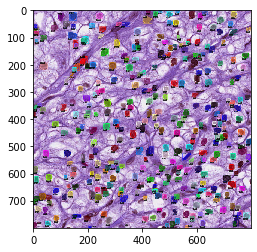

number of actual instances: 342


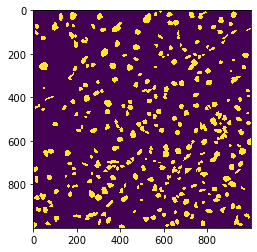

In [51]:
#for d in random.sample(dataset_dicts_nuclei_valid, 10):
for n, d in enumerate(dataset_dicts_nuclei_valid[28:29]):
    im = cv2.imread(str(d["file_name"]))
    outputs = predictor(im)
    n_predicted = len(outputs['instances'])
    print(f'number of predicted instances: {n_predicted}')
    v = Visualizer(im[:, :, ::-1],
                   metadata=nuclei_metadata_valid, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #cv2_imshow(v.get_image()[:, :, ::-1])
    show_np(v.get_image()[:, :, ::-1])
    
    path = d["file_name"]
    masks = None
    try:
        masks = [open_mask_as_np(mp) for mp in get_masks_path_from_id(path.stem, base_path=path.parent.parent.parent).ls()]    
    except FileNotFoundError:
        masks = get_mask_list_from_rle_for_one_id(path.stem, df_rle_labels, shape=(width,height))
    print(f'number of actual instances: {len(masks)}')
    show_np(merge_masks(masks, shape=(masks[0].shape[0], masks[0].shape[1])))

## Test set

In [19]:
DatasetCatalog.clear()

In [20]:
img_paths_test = [path/'images'/f'{path.name}.png' for path in STAGE2_TEST.ls()];len(img_paths_test)
DatasetCatalog.register("nuclei_test", lambda : get_nuclei_dicts(img_paths_test, isTestSet=True))
MetadataCatalog.get(f"nuclei_test").set(thing_classes=["nucleus"])
cfg.DATASETS.TEST = ("nuclei_test", )
cfg.MODEL.DEVICE='cuda'
predictor = DefaultPredictor(cfg)

In [ ]:
nuclei_metadata_test = MetadataCatalog.get(f"nuclei_test")
for p in random.sample(img_paths_test, 5):
    img = cv2.imread(str(p))
    pred = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=nuclei_metadata_test, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE   
    )
    v = v.draw_instance_predictions(pred["instances"].to("cpu"))
    #cv2_imshow(v.get_image()[:, :, ::-1])
    show_np(v.get_image()[:, :, ::-1])

### get predictions for stage2 test dataset of dsb 2018

In [ ]:
preds = {}
for p in tqdm(img_paths_test):
    img = cv2.imread(str(p))
    with torch.no_grad():
        pred = predictor(img)
    preds[p.stem] = (pred["instances"].to("cpu"))
    del pred
    torch.cuda.empty_cache()

### create submission for stage2 test dataset of dsb 2018

In [33]:
df_sub = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])

In [49]:
for i, pred in tqdm(list(preds.items())[:]):
    masks = pred.get('pred_masks')
    if len(masks) == 0:
        df_sub = df_sub.append({'ImageId': i, 'EncodedPixels': ''}, ignore_index=True)
    else:
        ###
        # the competition evaluation at kaggle throws an error, if an encoded pixel belongs to more than one object
        ###
        mask_merged = None
        for mask in masks:
            mask = mask.int()
            if mask_merged == None:
                mask_merged = mask
            else:
                overlap = (mask == mask_merged).int()
                mask = mask - overlap
                mask_merged = merge_masks([mask_merged, mask], shape=(mask.shape[0],mask.shape[1]))
            df_sub = df_sub.append({'ImageId': i, 'EncodedPixels': rle_from_list_to_string(rle_encode(mask))}, ignore_index=True)

In [50]:
df_sub

,ImageId,EncodedPixels
0,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,5131 5 5385 7 5640 8 5895 9 6145 15 6401 14 66...
1,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,5131 5 5385 7 5640 8 5895 9 6145 15 6401 14 66...
2,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,5131 5 5385 7 5640 8 5895 9 6145 15 6401 14 66...
3,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,5131 5 5385 7 5640 8 5895 9 6145 15 6401 14 66...
4,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,26739 6 26993 9 27248 11 27503 12 27758 14 280...
...,...,...
62544,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,27417 4 27830 8 28243 11 28656 13 29069 14 294...
62545,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,60510 12 60525 13 60922 33 61335 36 61748 38 6...
62546,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,14196 12 14610 14 15023 15 15438 15 15852 15 1...
62547,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,102134 4 102546 7 102959 8 103371 10 103784 11...


In [51]:
submission_path = Path('./submission_detectron2_1.csv')

In [52]:
df_sub.to_csv(submission_path, index=False)

In [53]:
pd.read_csv(submission_path)

,ImageId,EncodedPixels
0,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,5131 5 5385 7 5640 8 5895 9 6145 15 6401 14 66...
1,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,5131 5 5385 7 5640 8 5895 9 6145 15 6401 14 66...
2,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,5131 5 5385 7 5640 8 5895 9 6145 15 6401 14 66...
3,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,5131 5 5385 7 5640 8 5895 9 6145 15 6401 14 66...
4,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,26739 6 26993 9 27248 11 27503 12 27758 14 280...
...,...,...
62544,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,27417 4 27830 8 28243 11 28656 13 29069 14 294...
62545,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,60510 12 60525 13 60922 33 61335 36 61748 38 6...
62546,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,14196 12 14610 14 15023 15 15438 15 15852 15 1...
62547,34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569...,102134 4 102546 7 102959 8 103371 10 103784 11...
